# [ICR - Identifying Age-Related Conditions](https://www.kaggle.com/competitions/icr-identify-age-related-conditions)

The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions `Class 1`, or none of the three medical conditions `Class 0`. You will create a model trained on measurements of health characteristics.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Makes the notebook more readable
import warnings
warnings.filterwarnings("ignore") 

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline



from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import lightgbm as lgb


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from IPython.display import display
from pprint import pprint

#### Dataset description:

* **train.csv** - The training set.
    * **Id** Unique identifier for each observation.
    * **AB-GL** Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
    * **Class** A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
    
    

* **greeks.csv** - Supplemental metadata, only available for the training set.
    * **Alpha** Identifies the type of age-related condition, if present.
    * **A** No age-related condition. Corresponds to class 0.
    * **B, D, G** The three age-related conditions. Correspond to class 1.
    * **Beta, Gamma, Delta** Three experimental characteristics.
    * **Epsilon** The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

#### Evaluation criteria

Submissions are evaluated using a **balanced logarithmic loss**. The overall effect is such that each class is roughly equally important for the final score.

The formula for the loss function is:
$$\text{Log Loss} = \frac{-\frac{1}{N_{0}} \sum_{i=1}^{N_{0}} y_{0 i} \log  p_{0 i} - \frac {1}{N_{1}} \sum_{i=1}^{N_{1}} y_{1 i} \log  p_{1 i} } { 2 }$$

where $N_{c}$ is the number of observations of class $c$, $\log$ is the natural logarithm, $y_{c i}$ is $1$ if observation $i$ belongs to class $c$ and $0$ otherwise, $p_{c i}$ is the predicted probability that observation $i$ belongs to class $c$.

In order to avoid the extremes of the log function, each predicted probability $p$ is replaced with $\max(\min(p,1-10^{-15}),10^{-15})$

We can **define a function** to calculate the loss:

In [3]:
def balanced_logarithmic_loss(y_true, y_pred):
    
    # N_c is the number of observations of class c
    N_0 = np.sum(y_true == 0, axis=0)
    N_1 = np.sum(y_true == 1, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss 
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

## Dataset Exploration
### The Big Picture

First off, we look at the data:

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

print(dataset_df.info())
print(greeks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

* There is some **data missing**, in particular the `BQ` and `EL` columns are around 10% empty. To deal with this we could fill the missing values in with the mean or median, drop the columns entirely, or a mix of both.
* Most of the columns are floats, except the **EJ column which has categorical data**, as mentioned in the dataset description. We will have to use an encoder to turn it into numerical data.
* The ``greeks`` dataset has no numerical data.

Let's merge both databases and see a sample of the data:

In [5]:
# Merge the databases for data exploration:
data_plus_greeks_df = pd.merge(dataset_df, greeks_df) # inner join

data_plus_greeks_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


We can look at the greeks dataset: 

In [6]:
for col in greeks_df.columns:
    if col != 'Id':
        print(greeks_df.value_counts(col))

Alpha
A    509
B     61
G     29
D     18
dtype: int64
Beta
C    407
B    202
A      8
dtype: int64
Gamma
M    445
N     64
H     53
B     18
A     11
F     10
E      8
G      8
dtype: int64
Delta
B    456
A     75
C     64
D     22
dtype: int64
Epsilon
Unknown      144
5/29/2019     24
6/26/2019     19
9/15/2020     17
8/29/2019     13
            ... 
4/11/2019      1
4/10/2019      1
4/1/2019       1
3/8/2018       1
1/11/2018      1
Length: 198, dtype: int64


The `Epsilon` attribute, which represents the date of the data collection, has many unknowns.

Let's plot the features of the dataset:

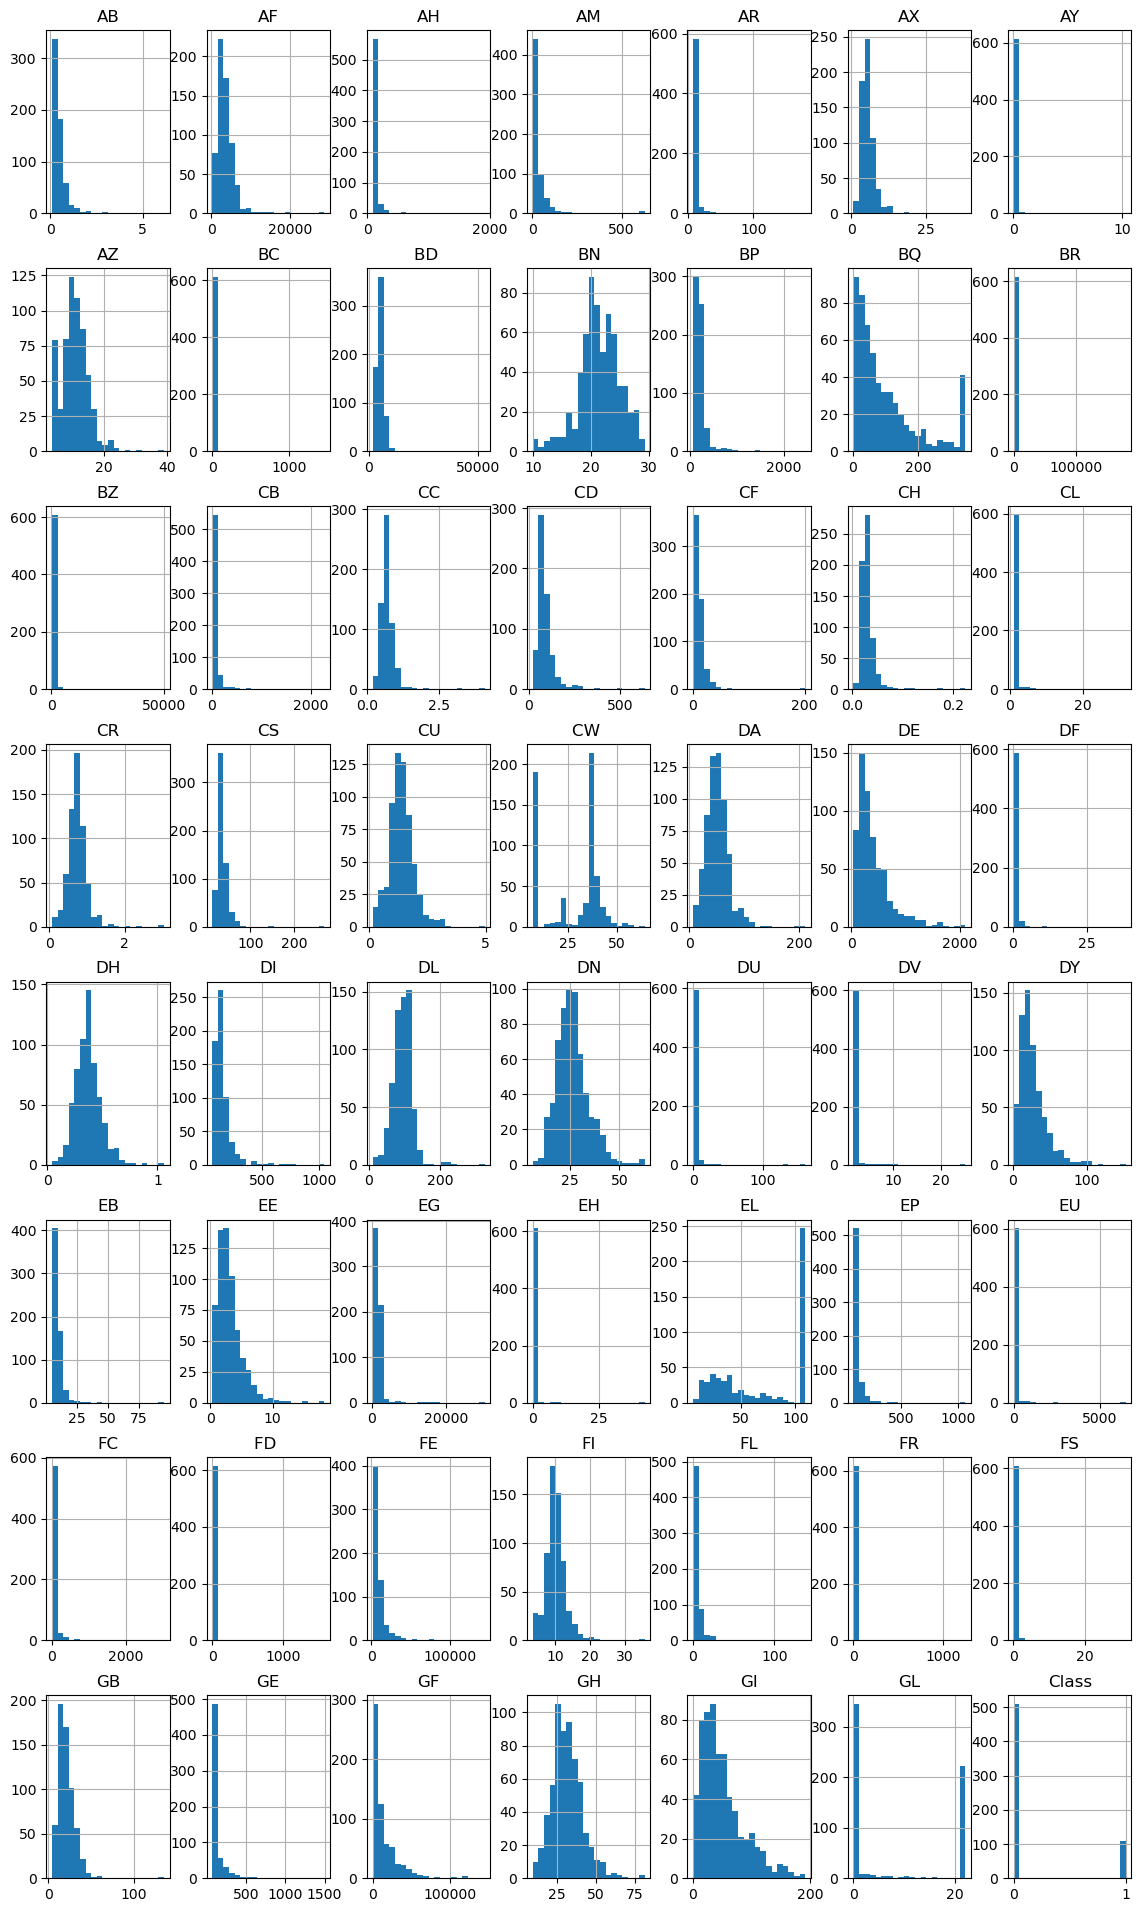

In [7]:
dataset_df.hist(bins = 20, figsize=(14,24))
plt.show()

This histograms show that:
* There are **more patients with `Class 0` than with `Class 1`** in the dataset.
* Most of the distributions have a **normal shape** (like `BN`) or a **tail-heavy shape** (like `DE`).
* There are some features which have **strange peaks**: they may have been **truncated** in some way (like `BQ`), or they may be heavily **bimodal** (like `GL`).

We have to take these observations into account when training the model:
* We can **normalize the tail-heavy distributions** by taking the log of each one, which may make the models more accurate.
* We can **eliminate some of the features** with strange distributions or **eliminate the truncated samples** from the dataset, as they may overfit the model to non-representative data.


Let's look at the unusual attributes again in detail:

,BQ,CW,EL,GL
count,557.000000,617.000000,557.000000,616.000000
mean,98.328737,27.165653,69.582596,8.530961
std,96.479371,14.645993,38.555707,10.327010
min,1.331155,7.030640,5.394675,0.001129
25%,27.834425,7.030640,30.927468,0.124392
50%,61.642115,36.019104,71.949306,0.337827
75%,134.009015,37.935832,109.125159,21.978000
max,344.644105,64.521624,109.125159,21.978000


array([[<Axes: title={'center': 'BQ'}>, <Axes: title={'center': 'CW '}>],
       [<Axes: title={'center': 'EL'}>, <Axes: title={'center': 'GL'}>]],
      dtype=object)

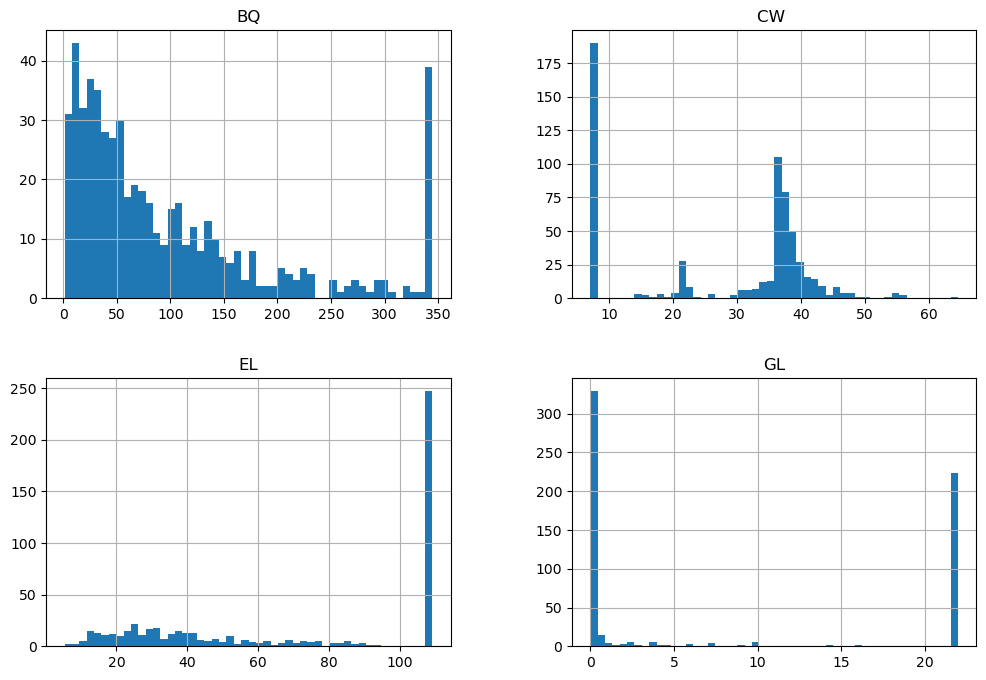

In [8]:
unusual_attributes = ['BQ', 'CW ', 'EL', 'GL']

display(dataset_df[unusual_attributes].describe())
display(dataset_df[unusual_attributes].hist(bins = 50, figsize=(12,8)))

## Data cleaning

To prepare the data for training, some adjustments are needed. 

First we will need to **split the data** into **training** and **validation** portions. To do this we have to take a sample from the dataset.

#### Sampling method

We can randomly sample the data, but since the dataset is small, there is a high risk of a skewed test sample.

For this dataset **stratified sampling** may be a better way to split the data. 

``Alpha`` is the type of age-related condition, so it's a good candidate for providing the stratums.

A decent validation size is around 20% of the data, especially when we have a small dataset.

In [9]:
dataset_alpha_df = pd.merge(dataset_df, greeks_df[['Id','Alpha']])

from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=99)

for train_index, val_index in split.split(dataset_alpha_df, dataset_alpha_df['Alpha']):
    strat_train_set = dataset_alpha_df.loc[train_index]
    strat_val_set = dataset_alpha_df.loc[val_index]

# Check that it worked:
print('Count of each Alpha type in the validation set:\n', strat_val_set["Alpha"].value_counts())
    
# Delete Id and Alpha, which won't be used for training
strat_train_set = strat_train_set.drop(['Id', 'Alpha'], axis = 1)
strat_val_set = strat_val_set.drop(['Id', 'Alpha'], axis = 1)

# Split into X and y:
X_train = strat_train_set.drop(['Class'], axis = 1)
y_train = strat_train_set.pop('Class')

X_valid = strat_val_set.drop(['Class'], axis = 1)
y_valid = strat_val_set.pop('Class')    

Count of each Alpha type in the validation set:
 A    102
B     12
G      6
D      4
Name: Alpha, dtype: int64


#### Feature engineering

To help the accuracy of our future model, we can transform the data in these ways:

* Applying a **log transformation** to the tail-heavy attributes.
* Modifying the attributes with unusual distributions in different ways:
    * Deleting the attributes entirely
    * Deleting the 

In [10]:
tail_heavy_attributes = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'BC', 'BD ', 'BP', 'BQ', 'BR',
       'BZ', 'CB', 'CD ', 'CF', 'CH', 'CL', 'CW ', 'DE', 'DF', 'DI', 'DU',
       'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GL']

not_tail_heavy_attributes = [col for col in dataset_df if col not in ['Id', 'Class', 'EJ'] + tail_heavy_attributes]

not_tail_heavy_attributes

['AZ', 'BN', 'CC', 'CR', 'CS', 'CU', 'DA', 'DH', 'DL', 'DN', 'FI', 'GH', 'GI']

We use the **one hot encoder** as mentioned, and also **scale** the numerical data, to make the model more accurate.

In [11]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="median"), # There are a few missing values
    StandardScaler(),
)

transformer_num_log = make_pipeline(  # Same as before, with added log transform
    SimpleImputer(strategy="median"), # There are a few missing values
    FunctionTransformer(lambda x: np.log(np.add(x, 1))), 
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
)


preprocessor = make_column_transformer(
    (transformer_num,
     not_tail_heavy_attributes),
    (transformer_num_log,
     tail_heavy_attributes),
    (transformer_cat,
     make_column_selector(dtype_include=object)),
)

preprocessor.fit(X_train)  # Fit only on training data
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)  # Apply the same transformation to the validation data

## Model selection

The data is now ready for training. It is time to choose an appropriate model.

Having taken a look at the data, the standard approaches would be using an **SVM**, a **random decision forest** or **gradient boosting**. We can also try using **logistic regression** or a small **neural network**.

### Setting a baseline - Random Forest

Let's use a **random forest** to set a baseline score. Then we will have a reference point for exploring other models.

In [12]:
rf = RandomForestClassifier(random_state=99)
rf.fit(X_train, y_train)

# Predict probability of sample being in each class
y_pred = rf.predict_proba(X_valid) # The columns of y_pred are [P(being in class 0), P(being in class 1)]
print('The score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred[:,1]))

The score is: 0.42478640270601487


We have set a score of around **0.42** with this basic approach.

#### Tuning the baseline

Let's improve the model further by changing the hyperparameters.

We can look at the [sk-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#parameters) to learn which parameters are recommended to modify.

To find the optimal hyperparameters, sk-learn has the ``RandomizedSearchCV`` optimizer. We just have to set the grid that it will search:

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)]
# Number of features to consider at every split
max_features = [None, 'sqrt', 0.3, 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [None, 'sqrt', 0.3, 1.0],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400]}


In [14]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, # 3-fold cross validation 
    verbose = 1, 
    random_state = 99, 
    n_jobs = -1 # use all processors
)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [None, 'sqrt', 0.3,
                                                         1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=99, verbose=1)

In [15]:
y_pred = rf_random.predict_proba(X_valid) # The columns of y_pred are [P(being in class 0), P(being in class 1)]
print('The tuned score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred[:,1]))

binary_y_pred = rf_random.predict(X_valid) # y_pred is a 1D array with the actual predictions (zeros and ones)
print('The accuracy is:', accuracy_score(y_valid, binary_y_pred))

print('\nThe best parameters are:', rf_random.best_params_)

The tuned score is: 0.36068258740636294
The accuracy is: 0.9274193548387096

The best parameters are: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 100, 'bootstrap': False}


With some basic hp-tuning, we got a better score of around **0.38**.
It would be possible to tune it further, but we can do it after exploring other models.

### Gradient Boosting
Usually gradient boosting can achieve a better accuracy score than a basic random forest. We can use the ``LightGBM`` library:

In [16]:
lgb_train, lgb_valid = lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_valid, label=y_valid)

params = {'objective': 'binary',
          'metric': 'binary_logloss',
         }


gbm = lgb.train(params, train_set = lgb_train, num_boost_round = 60, valid_sets=[lgb_valid], callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Info] Number of positive: 86, number of negative: 407
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6953
[LightGBM] [Info] Number of data points in the train set: 493, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174442 -> initscore=-1.554466
[LightGBM] [Info] Start training from score -1.554466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [17]:
y_pred = gbm.predict(X_valid, num_iteration = gbm.best_iteration)
print('\nThe score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred))


The score is: 0.363693563762105


As expected, the GBM performs better than even the tuned random forest, achieving a score of around **0.36**. 

Tuning it manually (or automatically using `Optuna`) may lower it further.

### SVM

Support vector machines have a low computational cost, while retaining good accuracy.

The output of an SVM does not give an approximate probability, and has to be modified to fit the constraints of the problem. Here we are using the `predict_proba()` method to do that. This inference of probability is not perfect. We may be introducing error by doing this, but it is hard to imagine a better way.

The evaluation is based on the balanced log loss, therefore an SVM may be inferior to the previous methods.

We can test a few of them below:

In [18]:
def print_score(y_pred, y_valid, binary_y_pred):
    print('\nThe accuracy is:', accuracy_score(y_valid, binary_y_pred))
    print('\nThe score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred[:,1]))  

print('------------Linear SVM------------')
linear_svm = SVC(kernel='linear', probability = True, random_state = 99)
linear_svm.fit(X_train, y_train)

binary_y_pred = linear_svm.predict(X_valid)
y_pred = linear_svm.predict_proba(X_valid)


print_score(y_pred, y_valid, binary_y_pred)



print('\n----------Polynomial SVM----------')
poly_svm = SVC(kernel='poly', degree=2, gamma='auto', probability = True, random_state = 99)
poly_svm.fit(X_train, y_train)

binary_y_pred = poly_svm.predict(X_valid)
y_pred = poly_svm.predict_proba(X_valid)

print_score(y_pred, y_valid, binary_y_pred)



print('\n------------Radial SVM------------')
radial_svm = SVC(kernel='rbf', gamma=1, probability = True, random_state = 99)
radial_svm.fit(X_train, y_train)

binary_y_pred = radial_svm.predict(X_valid)
y_pred = radial_svm.predict_proba(X_valid)

print_score(y_pred, y_valid, binary_y_pred)

------------Linear SVM------------

The accuracy is: 0.9112903225806451

The score is: 0.48189647513255157

----------Polynomial SVM----------

The accuracy is: 0.8870967741935484

The score is: 0.512405243091666

------------Radial SVM------------

The accuracy is: 0.8225806451612904

The score is: 0.983876439323679


The best score we got is around **0.48** on the linear SVM. The score may be improved by tuning.

The accuracy scores were also lower than the tuned random forest.

#### Tuning the SVM

In this case there are less hyperparameters, so using a `GridSearchCV` is not as computationally intensive. 

In [19]:
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear'],
              'probability': [True],
              'random_state': [99]
             } 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

binary_y_pred = best_svm.predict(X_valid)
y_pred = best_svm.predict_proba(X_valid)

print_score(y_pred, y_valid, binary_y_pred)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best params: {'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'probability': True, 'random_state': 99}

The accuracy is: 0.9112903225806451

The score is: 0.43458417967586405


The model has improved giving a score of **0.43**, but it still is performing worse than our baseline.

### Neural Network
On small datasets, neural networks tend to overfit. To prevent this we will use a simple model with two **hidden layers** and set up **dropout layers**.

For the output, we use a **sigmoid** activation layer, representing the probability of a sample being in ``Class 1``.

In [20]:
tf.random.set_seed(99)
model = keras.Sequential([
    layers.BatchNormalization(input_shape = [X_train.shape[1]]),
    
    layers.Dense(128, activation = 'elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    

    layers.Dense(8, activation = 'elu'),
    layers.BatchNormalization(),
    layers.Dropout(.125),
    
    layers.Dense(1, activation = 'sigmoid')
])

In [21]:
model.compile(
    optimizer = 'adam',
    metrics = ['binary_accuracy'],
    loss = 'binary_crossentropy',
)

Epoch 1/200
2/2 [==============================] - 2s 253ms/step - loss: 0.8904 - binary_accuracy: 0.4604 - val_loss: 0.6741 - val_binary_accuracy: 0.6290
Epoch 2/200
2/2 [==============================] - 0s 31ms/step - loss: 0.7684 - binary_accuracy: 0.5274 - val_loss: 0.6298 - val_binary_accuracy: 0.6371
Epoch 3/200
2/2 [==============================] - 0s 29ms/step - loss: 0.7282 - binary_accuracy: 0.5781 - val_loss: 0.5932 - val_binary_accuracy: 0.6774
Epoch 4/200
2/2 [==============================] - 0s 32ms/step - loss: 0.7205 - binary_accuracy: 0.5842 - val_loss: 0.5640 - val_binary_accuracy: 0.6935
Epoch 5/200
2/2 [==============================] - 0s 30ms/step - loss: 0.6636 - binary_accuracy: 0.6227 - val_loss: 0.5407 - val_binary_accuracy: 0.7177
Epoch 6/200
2/2 [==============================] - 0s 29ms/step - loss: 0.6382 - binary_accuracy: 0.6207 - val_loss: 0.5210 - val_binary_accuracy: 0.7258
Epoch 7/200
2/2 [==============================] - 0s 32ms/step - loss: 0.6

<Axes: title={'center': 'Accuracy'}>

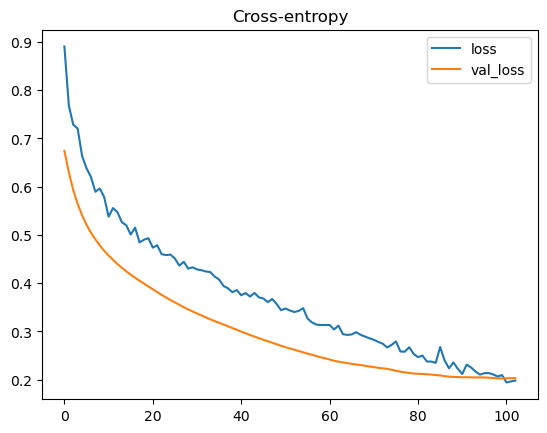

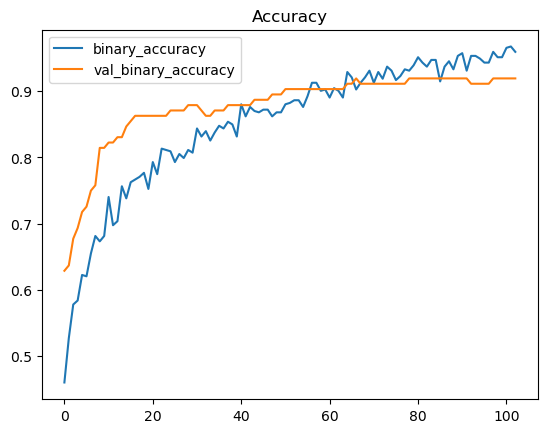

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
    callbacks=[early_stopping],
    verbose = 1
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [23]:
y_pred = model.predict(X_valid)
print('\nThe score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred.flatten()))

4/4 [==============================] - 0s 2ms/step

The score is: 0.40662597178591714


We get a score of **0.39**.

## Final model selection

The model that performed best was the **gradient boosting machine**, even without tuning. Therefore it seems to be a good choice for the actual submission. 

Let's tune it a bit with `Optuna` to see if we can improve the performance:

In [24]:
import optuna

def save_best_callback(study, trial):
    """
    Each iteration of the study, it saves the best trial, so that it can be used later
    """
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_booster', value=trial.user_attrs['best_booster'])
        
        
def objective(trial):
    lgb_train = lgb.Dataset(X_train, label=y_train, params={'verbose': -1}, free_raw_data=False) 
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, params={'verbose': -1}, free_raw_data=False)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1
    }
 
    gbm = lgb.train(params, lgb_train, verbose_eval = False)
    trial.set_user_attr(key='best_booster', value=gbm)
    y_pred = gbm.predict(X_valid)
    
    loss = balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred)
    return loss

# Start minimizing the loss function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, callbacks=[save_best_callback])

# Get the best performing model 
best_model = study.user_attrs['best_booster']
y_pred = best_model.predict(X_valid)

[I 2023-06-16 18:28:24,479] A new study created in memory with name: no-name-ff1f6eee-3e26-4deb-acb5-9e6d5dbf4543
[I 2023-06-16 18:28:24,718] Trial 0 finished with value: 0.31481710911123406 and parameters: {'lambda_l1': 7.23956684236207e-07, 'lambda_l2': 0.016187763971738316, 'num_leaves': 134, 'feature_fraction': 0.9630056240722289, 'bagging_fraction': 0.6560434692586348, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 0 with value: 0.31481710911123406.
[I 2023-06-16 18:28:24,851] Trial 1 finished with value: 0.5087193947694312 and parameters: {'lambda_l1': 0.004855474137962632, 'lambda_l2': 0.00011803727483756328, 'num_leaves': 2, 'feature_fraction': 0.7974948767185059, 'bagging_fraction': 0.40463108903396433, 'bagging_freq': 1, 'min_child_samples': 77}. Best is trial 0 with value: 0.31481710911123406.
[I 2023-06-16 18:28:25,014] Trial 2 finished with value: 0.38530350859291307 and parameters: {'lambda_l1': 0.003409244519043134, 'lambda_l2': 1.3586278324296656e-08, 'num_l

In [25]:
print('\nThe best model\'s score is:', balanced_logarithmic_loss(y_true = y_valid , y_pred = y_pred))
print('\nThe parameters used for the best model were:')
pprint(study.best_trial.params)


The best model's score is: 0.2739003661758214

The parameters used for the best model were:
{'bagging_fraction': 0.4830674195035054,
 'bagging_freq': 4,
 'feature_fraction': 0.94684801737468,
 'lambda_l1': 3.5011319312575934e-07,
 'lambda_l2': 0.049671026800073216,
 'min_child_samples': 46,
 'num_leaves': 154}


We got a score of around **0.25**, which is a the best yet. It would be possible to improve slightly by doing another optimization step, but the performance is quite good already.

We are ready to use this model in the final phase.

## Predicting on the test data

We will **prepare the test data** in the same manner that we did before:

In [26]:
# Split into X and y
X = dataset_df.copy()
# Remove Id, it has no relevant information
X.pop('Id') 

# Remove target
y = X.pop('Class')

# Cast the target from int to float
y = y.astype('float64')

# Load test data
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
X_test = test_df.copy() 

# The test database doesn't include the Class column, so we don't have to remove it

# Remove the IDs for the training phase, and store them to use in the submission phase
X_test_Ids = X_test.pop('Id')


# Use the previously defined preprocessor to transform the data

# INFO: If you train a model again from this point, it is better to fit_transform().
# Since we used early stopping, we won't be training the model further.
X = preprocessor.transform(X)


# Apply the same transformation to the test data
X_test = preprocessor.transform(X_test)  

# Get the predictions
y_prediction = best_model.predict(X_test)

### Making the submission file

For each id in the test set, you must predict a probability for each of the two classes. The file should contain a header and have the following format:
```
Id,class_0,class_1
00eed32682bb,0.5,0.5
010ebe33f668,0.5,0.5
02fa521e1838,0.5,0.5
040e15f562a2,0.5,0.5
046e85c7cc7f,0.5,0.5
...
```

We now proceed to construct this submission file:

In [27]:
# The predicted values for y are equivalent to the probability of a patient being in class 1
submission = pd.DataFrame(y_prediction, columns = ['Class 1'])

# We add the identification column back in
submission['Id'] = X_test_Ids

# The probability of being in class 0 is the inverse of them being in class 1
submission['Class 0'] = 1 - submission['Class 1']

# Rearranges the column order to fit the submission criteria
submission = submission[['Id', 'Class 0', 'Class 1']]
submission

,Id,Class 0,Class 1
0,00eed32682bb,0.649281,0.350719
1,010ebe33f668,0.649281,0.350719
2,02fa521e1838,0.649281,0.350719
3,040e15f562a2,0.649281,0.350719
4,046e85c7cc7f,0.649281,0.350719


### Submitting to the competition

In [28]:
# Saves the dataframe to a submission.csv file
submission.to_csv(header = ['id', 'class_0', 'class_1'], index = False, path_or_buf = '/kaggle/working/submission.csv')